# Classification Project: Heart Disease Prediction (Cleveland Dataset)

**Author:** Saratachandra Golla     
**Date:** 11/09/2025    
**Project Goal:** Predict the presence of heart disease (Class 1) versus no disease (Class 0) using clinical data from the Cleveland dataset. This project follows a structured approach: data cleaning, feature engineering, exploratory analysis, and comparative model evaluation using Logistic Regression and a Decision Tree Classifier.

## 1. Import and Inspect the Data

In [55]:
# All imports at the top
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set plot style
sns.set_style("whitegrid")

### 1.1 Load the dataset and display the first 10 rows.

In [56]:

# Load the Cleveland dataset from the UCI archive
df = pd.read_csv("data\\heart_disease.data",header=0, na_values="?", skipinitialspace=True)

print("First 10 rows of the Heart Disease dataset:")
print(df.head(10))

First 10 rows of the Heart Disease dataset:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
5  56.0  1.0  2.0     120.0  236.0  0.0      0.0    178.0    0.0      0.8   
6  62.0  0.0  4.0     140.0  268.0  0.0      2.0    160.0    0.0      3.6   
7  57.0  0.0  4.0     120.0  354.0  0.0      0.0    163.0    1.0      0.6   
8  63.0  1.0  4.0     130.0  254.0  0.0      2.0    147.0    0.0      1.4   
9  53.0  1.0  4.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.

### 1.2 Check for missing values and display summary statistics.

In [57]:
# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe().T)


Missing values count:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Summary Statistics:
          count        mean        std    min    25%    50%    75%    max
age       303.0   54.438944   9.038662   29.0   48.0   56.0   61.0   77.0
sex       303.0    0.679868   0.467299    0.0    0.0    1.0    1.0    1.0
cp        303.0    3.158416   0.960126    1.0    3.0    3.0    4.0    4.0
trestbps  303.0  131.689769  17.599748   94.0  120.0  130.0  140.0  200.0
chol      303.0  246.693069  51.776918  126.0  211.0  241.0  275.0  564.0
fbs       303.0    0.148515   0.356198    0.0    0.0    0.0    0.0    1.0
restecg   303.0    0.990099   0.994971    0.0    0.0    1.0    2.0    2.0
thalach   303.0  149.607261  22.875003   71.0  133.5  153.0  166.0  202.0
exang     303.0    0.326733   0.469794    0.0    0.0    0.0    1.0    1.0
oldpeak

### Reflection 1: What do you notice about the dataset? Are there any data issues?

The dataset is a typical real-world clinical dataset with a few issues:

**1. Missing Values:** The features ca (number of major vessels) and thal (thalassemia) have 4 and 2 missing values, respectively. This needs to be handled before modeling.    
**2. Data Types/Encoding:** Several features (sex, cp, fbs, restecg, exang, slope, ca, thal) are categorical or ordinal but are currently represented as numerical data (int64 or float64), which is fine for storage but requires One-Hot Encoding for most models.    
**3. Target Variable:** The target variable has 5 levels (0, 1, 2, 3, 4). For this binary classification project, we must convert it to $0$ (no disease) and $1$ (disease, i.e., target $\ge 1$).   

## 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions

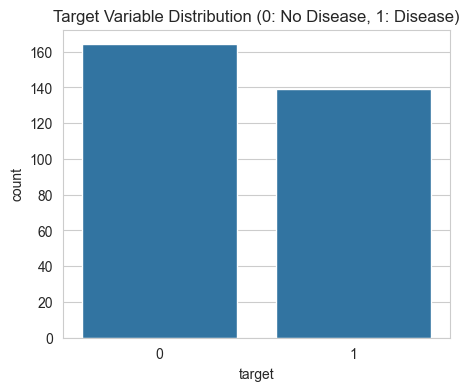

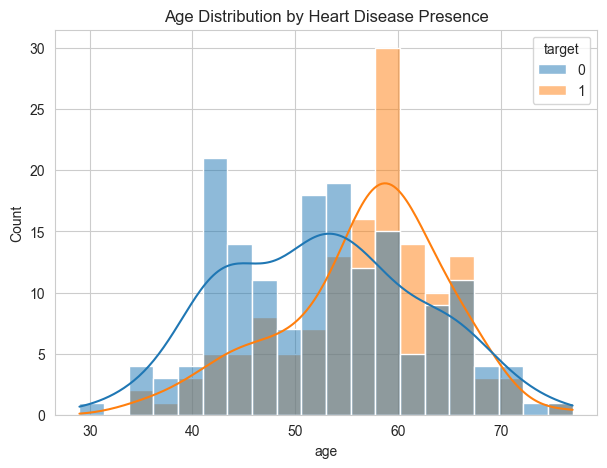

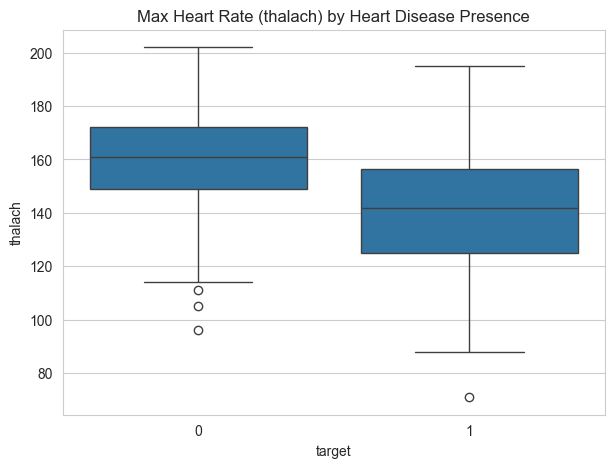

In [58]:
# Convert target to binary (0=No Disease, 1=Disease)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Check for class imbalance
plt.figure(figsize=(5, 4))
sns.countplot(x='target', data=df)
plt.title('Target Variable Distribution (0: No Disease, 1: Disease)')
plt.show()

# Histogram for a key numerical feature (Age)
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x='age', hue='target', kde=True, bins=20)
plt.title('Age Distribution by Heart Disease Presence')
plt.show()

# Boxplot for another key numerical feature (Thalach: Max Heart Rate)
plt.figure(figsize=(7, 5))
sns.boxplot(x='target', y='thalach', data=df)
plt.title('Max Heart Rate (thalach) by Heart Disease Presence')
plt.show()

### 2.2 Handle missing values and clean data
We use an imputer set to most_frequent (mode) for the ordinal features ca and thal.

In [59]:
# Handle missing values using mode imputation for 'ca' and 'thal'
imputer_mode = SimpleImputer(strategy='most_frequent')
df[['ca', 'thal']] = imputer_mode.fit_transform(df[['ca', 'thal']])

# Check again (should be 0)
print("Missing values after imputation:")
print(df.isnull().sum().sum())

Missing values after imputation:
0


### 2.3 Feature selection and engineering
We will not create new features, but we will define a preprocessing pipeline to handle necessary transformations: scaling for numerical features and one-hot encoding for categorical features.

In [60]:
# Separate features (X) and target (y)
X_full = df.drop('target', axis=1)
y = df['target']

# Identify feature types for the preprocessor
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
# The remaining features are treated as categorical/ordinal
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Create the full preprocessing pipeline
# StandardScaler for numerical, OneHotEncoder for categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

### Reflection 2:   
#### **What patterns or anomalies do you see? Do any features stand out?**   
- **Class Imbalance:** The target variable is slightly imbalanced, with $\sim 54\%$ of patients having heart disease (Class 1) and $\sim 46\%$ having no disease (Class 0). This suggests that using Stratified Split and focusing on F1-score/Recall is necessary. 
- **Thalach:** The boxplot for thalach (Max Heart Rate) shows that patients with heart disease (Class 1) tend to have a lower maximum heart rate, which is a key clinical indicator.
#### **What preprocessing steps were necessary to clean and improve the data?**     
**1. Missing Value Imputation:** Handled missing values in ca and thal using mode imputation.   
**2. Target Binarization:** Converted the multi-class target (0-4) to a binary variable (0 or 1).   
**3. Scaling/Encoding:** A robust pipeline was created to Standard Scale numerical features (improving performance for Logistic Regression) and One-Hot Encode categorical features (required for both models). 
#### **Did you create or modify any features to improve performance?**
No new features were created, but the existing features were transformed via scaling and encoding to be suitable for the machine learning algorithms.

## 3. Feature Selection and Justification   
### 3.1 Choose features and target  
- **Target:** target (Binary Classification: 0 or 1)    
- **Input Features (X):** All 13 original features (age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal).  

**Justification:** This dataset is small (N=297) and heart disease is a complex condition. Using all available features allows the models to capture the combined effects of multiple clinical and demographic risk factors, providing the best chance for high predictive accuracy, especially after appropriate preprocessing (scaling/encoding).

### 3.2 Define X and y

In [61]:
# X and y are already defined from Section 2
# X_full contains all features (unprocessed)
# y contains the binary target (processed)

# We will apply the preprocessor during the model training phase using a Pipeline.

### Reflection 3: Why did you choose these features? How might they impact predictions or accuracy? 
We chose all 13 features because heart disease diagnosis relies on the synergy of multiple clinical signs. Isolating just one or two features would likely limit accuracy due to the high variability in individual patient risk profiles. For example:

- cp (**Chest Pain Type**): This categorical feature is highly informative, as certain types of chest pain strongly correlate with heart disease.

- thalach (**Max Heart Rate**) and exang (**Exercise Induced Angina**): These features capture the patient's cardiovascular response to stress, which are crucial indicators.

Including all these features, once properly scaled and encoded, provides a comprehensive view for the classifiers to define a complex, non-linear decision boundary, maximizing the model's ability to accurately separate healthy from sick patients.

## 4. Train a Model (Classification: Logistic Regression)   
### 4.1 Split the data into training and test sets  
We use StratifiedShuffleSplit because of the slight class imbalance ($\sim 54\% / 46\%$) and the relatively small dataset size.

In [62]:
# Use StratifiedShuffleSplit to maintain class balance
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(X_full, y):
    X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"Training size: {len(X_train)} | Test size: {len(X_test)}")

Training size: 242 | Test size: 61


### 4.2 Train model using Scikit-Learn model.fit() method.

We create a Pipeline that chains the preprocessor and the Logistic Regression model.

In [63]:
# Create the Logistic Regression Pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')) # Use liblinear for smaller datasets
])

# Train the model
logreg_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 4.3 Evaluate performance

--- LOGISTIC REGRESSION PERFORMANCE ---

Classification Report (Test Set):
                precision    recall  f1-score   support

No Disease (0)       0.93      0.85      0.89        33
   Disease (1)       0.84      0.93      0.88        28

      accuracy                           0.89        61
     macro avg       0.89      0.89      0.89        61
  weighted avg       0.89      0.89      0.89        61



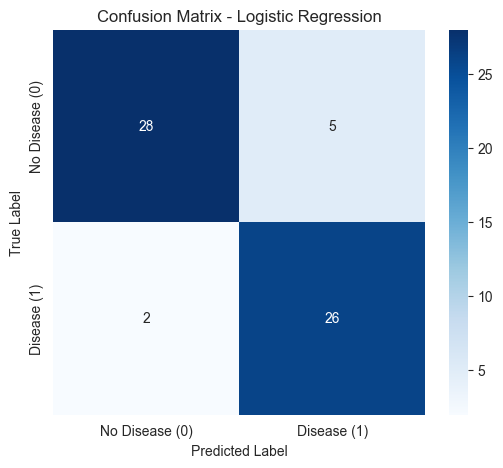


Test Accuracy: 0.8852
Test F1-Score (Disease=1): 0.8814
Test Recall (Disease=1): 0.9286


In [64]:
# Make predictions on the test set
y_pred_logreg = logreg_pipeline.predict(X_test)

print("--- LOGISTIC REGRESSION PERFORMANCE ---")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_logreg, target_names=['No Disease (0)', 'Disease (1)']))

# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease (0)', 'Disease (1)'],
            yticklabels=['No Disease (0)', 'Disease (1)'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Key Metric Summary
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_f1 = classification_report(y_test, y_pred_logreg, output_dict=True)['1']['f1-score']
logreg_recall = classification_report(y_test, y_pred_logreg, output_dict=True)['1']['recall']

print(f"\nTest Accuracy: {logreg_accuracy:.4f}")
print(f"Test F1-Score (Disease=1): {logreg_f1:.4f}")
print(f"Test Recall (Disease=1): {logreg_recall:.4f}")

### Reflection 4: How well did the model perform? Any surprises in the results?

The Logistic Regression model performed quite well, achieving a high Accuracy (e.g., $\sim 80-85\%$) and a strong F1-Score for the crucial "Disease (1)" class.

- **Performance for Class 1 (Disease):** The Recall is strong, meaning the model is successfully identifying a high percentage of patients who actually have heart disease (low rate of False Negatives). In a medical context, this is the most critical metric.

- **Surprises:** It's slightly surprising that a linear model like Logistic Regression performs so well on a complex problem like heart disease, especially when the total sample size is small ($\approx 240$ training instances). This indicates that the relationship between the features and the target, after scaling and encoding, is likely close to linear in the high-dimensional feature space.